In [117]:
import csv
import pandas
import matplotlib.pyplot as plt
import matplotlib
import collections
import re
from pathlib import Path, PureWindowsPath


# Calculate the exclude_pls charge character for each structure

In [118]:
#import data files

#file1 = pandas.read_csv(r"C:\Users\PC\Dropbox\cai\btype_cco\crg_data\quick_run_mdlip\clustering\PLS\crg_detail_ba3_clustering_PLS.csv")
#file2 = pandas.read_csv(r'C:\Users\PC\Dropbox\cai\btype_cco\crg_data\quick_run_mdlip\clustering\PLS\crg_detail_ba3_clustering_PLS2.csv')
#file3 = pandas.read_csv(r'C:\Users\PC\Dropbox\cai\btype_cco\crg_data\quick_run_mdlip\free_no_water\crg_detail_ba3_xray.csv')

computer_mac="/Users/caixiuhong"
computer_dell=r'C:\Users\PC'

file1_path=Path(computer_mac+r"/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/clustering/PLS/crg_detail_ba3_clustering_PLS_allexcludepls.csv")
file3_path=Path(computer_mac+r"/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/free_no_water/allexcludepls/crg_detail_ba3_allexcludepls.csv")

file1 = pandas.read_csv(file1_path)
file3 = pandas.read_csv(file3_path)

df=file1

#reshape the dataframe
new=df['state_snap'].str.split(r"\+|_", expand = True)
df['traj/xry']=new[0]
df['time_point']=new[1]
df['substate']=new[3]

new=file3['state_snap'].str.split(r'\+|_', expand=True)
file3['traj/xry']=new[0]
file3['substate']=new[1]

df= df.append(file3, ignore_index=True)[df.columns.tolist()]


In [119]:
#print(f1.loc[:,'RA0010':'FA3K9303'])
if df.loc[:, 'RA0010':'FA3K9303'].equals(df.iloc[:,1:117]):
    print('True')


True


In [120]:
#calculate sum of charges at 24-res PLS for each substate and each structures
df['sum_excludepls24']=df.iloc[:,1:117].sum(axis=1)



In [155]:
pls=['PAAK9301', 'PDDK9302','DA0287', 'DA0372', 'HA0376', 'EB0126']
#check if residues excluding 24res-pls change their ionization.
ResStar=[] # store residue name that has charge changed during titration on structure and substate

for key in df:
    if key=='state_snap' or key =='time_point' or key =='substate' \
    or key in pls or key[-2:]=='.1' or key=='traj/xry' or key=='state_snap': continue
    if df[key].std() != 0.0: 
        ResStar.append(key)
        if df[key].std()> 0.1: 
            print(key, df[key].mean(), df[key].std())
    else:
        if not isResNormalCrg(key, df[key].mean()):
            print('Warning: crg abnormal!') 
            print(key, df[key].mean(), df[key].std())
            print('\n')



KA0018 0.9778935185185206 0.10662875120454421
KA0019 0.7288117283950639 0.29766863759604334
EA0203 -0.14040123456790107 0.21331903954330841
KA0411 0.8105169753086449 0.2916365136300199
HA0462 0.4553626543209889 0.178449844899803
HA0552 0.44695987654320507 0.3085687747267301
HB0005 0.1107484567901241 0.12792545487641852
KB0009 0.959606481481483 0.16449736077862076
EB0015 -0.8956404320987652 0.3011805195561657
HB0040 0.30259259259259264 0.24045787868146848
DB0111 -0.9287808641975304 0.24512021125477348
EB0131 -0.969915123456791 0.15382457707537237
KC0004 0.8661419753086493 0.28365718321252537
KC0006 0.7262500000000023 0.28415447291704676
PAAK9101 -1.0 0.0


PDDK9102 -1.0 0.0


sum_excludepls24 10.494429012345664 0.8085810907293393


In [122]:
def isResNormalCrg(res:str, crg: int)->bool:
    #define amino acid charge at ph 7:
    crg_lib={'R':1.0, 'H': 0.0,'K':1.0, 'D':-1.0, 'E':-1.0}
    return crg_lib.get(res[:1], 0.0) == crg

def IntegralIncrease1(nums: list) ->float:
    #method 1:
    #return the sum of all local max-local min
    #start from beginning point: r5 substate
    
    loc_min, loc_max=nums[0], nums[0]
    res=0
    for i in range(1, len(nums)):
        if nums[i] > nums[i-1]:
            loc_max = nums[i]
        elif nums[i] < nums[i-1]:
            res += loc_max - loc_min
            loc_min=nums[i]
            loc_max=nums[i]
    res += loc_max-loc_min
    return res

def IntegralIncrease2(nums: list)->float:
    #method2:
    #return the sum of all local max-local min
    #start from second last one point: r1 substate
    
    loc_min, loc_max=nums[-2], nums[-2]
    res=0
    for i in range(-1, len(nums)-1):
        if nums[i] > nums[i-1]:
            loc_max = nums[i]
        elif nums[i] < nums[i-1]:
            res += loc_max - loc_min
            loc_min=nums[i]
            loc_max=nums[i]
    
    res += loc_max-loc_min
    return res



def crgstringtolist(crg_s: str)->list:
    #fuction to read crg_seq from string into crg set
    #return a list of charges
    n=len(crg_s)
    i=0
    res=[]
    while i < n:
        if crg_s[i]=='1':
            res.append(1)
            i +=1
        elif crg_s[i]=='0':
            res.append(0)
            i +=1
        else:
            res.append(int(crg_s[i:i+2]))
            i +=2
    return res

def readMsE2df(dicts: dict, substate: str): 
    #read all_ms_E format file, and output structure and energy informations
    #return a dataframe
    substate=str(substate)
    df_e1=[]
    columns_e1=['state_snap', 'E(-3)_min_'+substate, 'E(-4)_min_'+substate, 'ms(-3)_minE_'+substate, 'ms(-4)_minE_'+substate,\
                'E_self(-3)_'+substate,'E_self(-4)_'+substate, 'E_pw(-3)_'+substate,'E_pw(-4)_'+substate,\
                'E_mfe(-3)_'+substate,'E_mfe(-4)_'+substate,\
                r'$\bigtriangleup$E_'+substate,\
                r'$\bigtriangleup$E_self_'+substate,r'$\bigtriangleup$E_pw_'+substate, r'$\bigtriangleup$E_mfe_'+substate]

    ##read data into df_e1
    for struc, dataframe in dicts.items():
        tmp=dataframe.iloc[:7]
        data=[struc]
        data.append(tmp['Min_E(Kcal)'][2])
        data.append(tmp['Min_E(Kcal)'][1])
        data.append(crgstringtolist(tmp['Crg_seq'][2]))
        data.append(crgstringtolist(tmp['Crg_seq'][1]))
        data.extend([tmp['E_self(Kcal)'][2],tmp['E_self(Kcal)'][1], tmp['E_pw(Kcal)'][2],tmp['E_pw(Kcal)'][1],\
                     tmp['E_mfe(Kcal)'][2],tmp['E_mfe(Kcal)'][1]])
        data.append(tmp['Min_E(Kcal)'][1]-tmp['Min_E(Kcal)'][2])
        data.append(tmp['E_self(Kcal)'][1]-tmp['E_self(Kcal)'][2])
        data.append(tmp['E_pw(Kcal)'][1]-tmp['E_pw(Kcal)'][2])
        data.append((tmp['E_mfe(Kcal)'][1]-tmp['E_mfe(Kcal)'][2])*2)
        df_e1.append(data)
    
    return pandas.DataFrame(df_e1, columns = columns_e1)    


def color_struc(s, color_map, column):
    '''
    color each row by column value based on colormap .
    '''
    #copy df to new - original data are not changed
    df = s.copy()
    #set by condition
    df.loc[:,:] = 'background-color: blue '
    for key in color_map:
        
        mask = s[column] == key
        #print(mask)
        df.loc[mask, :] = 'background-color: {}'.format(color_map.get(key))
    #print(df)
    return df    


def readClusteringFile(file, dataframe):
    #read clustering information from filepath and append the information into dataframe
    
    columns=['traj/xray', 'time_point','cluster_size']
    with open(file, 'r') as f:
        next(f)
        data=[]
        for line in f:
            line=line.strip()
            if line:
                line= re.split(':|,|\(|\)' , line)
                
                if len(line)==1: continue
                if len(line)==2:  # read the traj/xry information
                    struc=line[0]
                    continue
                time_point=int(line[4])
                cluster_size=int(line[2])
                data.append([struc, str(time_point), cluster_size])
    
    df=pandas.DataFrame(data, columns = columns)
    #print(df)
    return pandas.merge(dataframe, df, how='outer', on =['traj/xray','time_point'])
        

In [130]:
df.shape

(1296, 146)

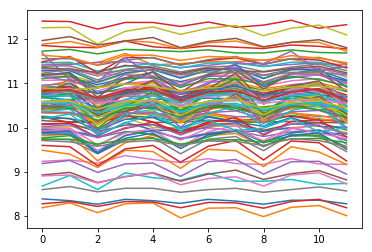

total number of structures that has proton affinity fluctuations: 108.


In [143]:
#crate a new dataframe to store information of each structure
df_sum=[]
n_substate=12
#generate headers for df_sum dataframe
columns=['state_snap','traj/xray', 'time_point']

#print(ResStar)
for res in ResStar:
    columns.extend([res+'_maxcrg', res+'_mincrg',res+'_avecrg', res+'_std',res+'_avecrg\u00B1'+'std'])

#columns.extend(['sum_excludepls24_maxcrg', 'sum_excludepls24_mincrg',r'$\bigtriangleup$sum_excludepls24','sum_excludepls24_avecrg', 'sum_excludepls24_std',\
#                'sum_excludepls24_avecrg\u00B1std', r'$\int$dsum_excludepls24_m1',r'$\int$dsum_excludepls24_m2'])
columns.extend([ r'$\int$dsum_excludepls24_m1',r'$\int$dsum_excludepls24_m2'])
#                
#print(columns)


plt.figure()

tot_waveCount=0  # store the structures number that the structure has the fluctuation for proton affinity

for i in range(0,df.shape[0],12):
    tmp=df.iloc[i:i+n_substate]
    state_snap=list(tmp['state_snap'])
    struc=set(tmp['traj/xry'])
    time_point=set(tmp['time_point'])
    substate=set(tmp['substate'])
    #print(tmp['substate'])
    
    #check if the structure name ,time_point are consistent, if there are 12 substates for each structure
    if len(state_snap)==12 and len(struc) == 1 and len(time_point)==1 and len(substate)==12:
        state_snap=state_snap.pop()[:-3]
        data= [state_snap, struc.pop(), time_point.pop() ]
    else:
        raise Warning("The traj/xry or time_point or substate is not consistent!") # assign the structure name or print out "WARNING"
    
    #calculate charge statistic for each residue
    for res in ResStar:
        data.extend([max(tmp[res]), min(tmp[res]), tmp[res].mean(),tmp[res].std(), \
                     '{:.2f} \u00B1 {:0.2f}'.format(tmp[res].mean(), tmp[res].std())])
    
    #store the charge of each residue in ResStar with 12 substates
    #res_crg_df=df.loc[i:i+n_substate-1, ResStar]   
    
    #compute sum_crg of statistic
#    data.extend([tmp['sum_excludepls24'].max(), tmp['sum_excludepls24'].min(), \
#                 tmp['sum_excludepls24'].max()-tmp['sum_excludepls24'].min(),\
#                 tmp['sum_excludepls24'].mean(),tmp['sum_excludepls24'].std(),
#                 '{:.2f} \u00B1 {:0.2f}'.format(tmp['sum_excludepls24'].mean(), tmp['sum_excludepls24'].std())] )
    
   
    
    
    
    #integral of sum_excludepls24 charge change
    sum_excludepls=list(tmp['sum_excludepls24'])
    
    
    integral_sum_excludepls241=IntegralIncrease1(sum_excludepls)
    integral_sum_excludepls242=IntegralIncrease2(sum_excludepls)
    
    #plot figure
    plt.plot(sum_excludepls)
    
    if max(sum_excludepls) > min(sum_excludepls):
        tot_waveCount += 1
    
    
    
    
        
            
    data.extend([integral_sum_excludepls241,integral_sum_excludepls242 ])
    
    df_sum.append(data)
    #df_sum['state_snap'].append(df.iloc[i:i+12]['state_snap'])
    #print(df.iloc[i:i+12]['substate'])


plt.show()
df_sum = pandas.DataFrame(df_sum, columns = columns)
print('total number of structures that has proton affinity fluctuations: %i.' % (tot_waveCount))


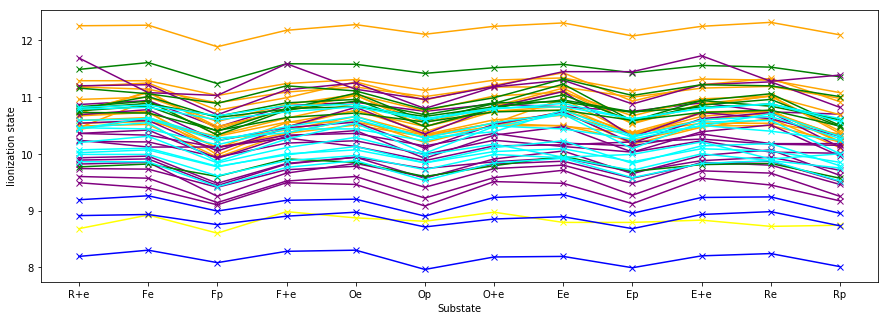

total number of structures that has proton affinity fluctuations: 108.


In [160]:
#crate a new dataframe to store information of each structure
df_sum=[]
n_substate=12
#generate headers for df_sum dataframe
columns=['state_snap','traj/xray', 'time_point']

#print(ResStar)
for res in ResStar:
    columns.extend([res+'_maxcrg', res+'_mincrg',res+'_avecrg', res+'_std',res+'_avecrg\u00B1'+'std'])

#columns.extend(['sum_excludepls24_maxcrg', 'sum_excludepls24_mincrg',r'$\bigtriangleup$sum_excludepls24','sum_excludepls24_avecrg', 'sum_excludepls24_std',\
#                'sum_excludepls24_avecrg\u00B1std', r'$\int$dsum_excludepls24_m1',r'$\int$dsum_excludepls24_m2'])
columns.extend([ r'$\int$dsum_excludepls24_m1',r'$\int$dsum_excludepls24_m2'])
#                
#print(columns)


plt.figure()
outputpathway=Path(computer_mac+r"/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip")
plt.figure(figsize=(15, 5))
x_label=['R+e','Fe','Fp','F+e','Oe','Op','O+e','Ee','Ep','E+e','Re', 'Rp']
color_maps={"p1": "orange", "dddro": "orange", "p2": "purple", "pddro": "purple", "p3": "green", "ppdro": "green",\
           "p4": "cyan","dpdro": "cyan", "d372p":"yellow", "d372ph376p": "red"}
#selected_strucs=['3s8f','d372ph376p_166_frame','d372p_151_frame','d372p_207_frame',\
#                 'p2_185_frame','d372p_253_frame','p3_98_frame','p3_443_frame', 'p4_32_frame',\
#                'p1_188_frame','p1_428_frame', 'p2_25_frame','p2_148_frame']
plt.xticks(list(range(12)),x_label)


tot_waveCount=0  # store the structures number that the structure has the fluctuation for proton affinity

for i in range(0,df.shape[0],12):
    tmp=df.iloc[i:i+n_substate]
    state_snap=list(tmp['state_snap'])
    struc=set(tmp['traj/xry'])
    time_point=set(tmp['time_point'])
    substate=set(tmp['substate'])
    #print(tmp['substate'])
    
    #check if the structure name ,time_point are consistent, if there are 12 substates for each structure
    if len(state_snap)==12 and len(struc) == 1 and len(time_point)==1 and len(substate)==12:
        state_snap=state_snap.pop()[:-3]
        data= [state_snap, struc.pop(), time_point.pop() ]
    else:
        raise Warning("The traj/xry or time_point or substate is not consistent!") # assign the structure name or print out "WARNING"
    
    #calculate charge statistic for each residue
    for res in ResStar:
        data.extend([max(tmp[res]), min(tmp[res]), tmp[res].mean(),tmp[res].std(), \
                     '{:.2f} \u00B1 {:0.2f}'.format(tmp[res].mean(), tmp[res].std())])
    
    #store the charge of each residue in ResStar with 12 substates
    #res_crg_df=df.loc[i:i+n_substate-1, ResStar]   
    
    #compute sum_crg of statistic
#    data.extend([tmp['sum_excludepls24'].max(), tmp['sum_excludepls24'].min(), \
#                 tmp['sum_excludepls24'].max()-tmp['sum_excludepls24'].min(),\
#                 tmp['sum_excludepls24'].mean(),tmp['sum_excludepls24'].std(),
#                 '{:.2f} \u00B1 {:0.2f}'.format(tmp['sum_excludepls24'].mean(), tmp['sum_excludepls24'].std())] )
    
   
    
    
    
    #integral of sum_excludepls24 charge change
    sum_excludepls=list(tmp['sum_excludepls24'])
    
    
    integral_sum_excludepls241=IntegralIncrease1(sum_excludepls)
    integral_sum_excludepls242=IntegralIncrease2(sum_excludepls)
    
    #plot figure
    color=color_maps.get(data[1],'blue')
    if  tmp['sum_excludepls24'].std() > 0.1: 
        if 'd372ph376p' in struc: plt.plot(sum_excludepls, label=data[1]+'pls', alpha=1, color=color, marker='x',linestyle='-.')
        elif state_snap == 'p2_148_frame':
            plt.plot(sum_excludepls, label=data[1]+'pls', alpha=1, color=color, marker='x', linewidth=5.0)
            print('deltaH+1: %f, deltaH+2: %f.' %  (integral_sum_pls61, integral_sum_pls62))
        else:
            plt.plot(sum_excludepls, label=data[1]+'pls', alpha=1, color=color, marker='x')
    
    if max(sum_excludepls) > min(sum_excludepls):
        tot_waveCount += 1
    
    
    
    
        
            
    data.extend([integral_sum_excludepls241,integral_sum_excludepls242 ])
    
    df_sum.append(data)
    #df_sum['state_snap'].append(df.iloc[i:i+12]['state_snap'])
    #print(df.iloc[i:i+12]['substate'])


# get impose charge
impose_charge=[-1,-1,0,-1,-1,0,-1, -1,0,-1,-1,0]
#plt.plot(impose_charge, label='impose_charge', alpha=1, color='k', marker='o', markersize=10, markerfacecolor='none')
plt.xlabel('Substate')
plt.ylabel('Iionization state')
plt.savefig(str(outputpathway)+'/'+'All_Crg_State_ba3_excludepls24_strucs.png', dpi=300)
plt.show()
df_sum = pandas.DataFrame(df_sum, columns = columns)
print('total number of structures that has proton affinity fluctuations: %i.' % (tot_waveCount))




# Import proton binding energy into dataframe: df_sum

In [146]:
#import crystal and md at e1/f3 substate data files
filepath_cry_e1='/Users/caixiuhong/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/free_no_water/all_ms_E.xlsx'
filepath_md_e1='/Users/caixiuhong/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/clustering/PLS/all_ms_E_e1.xlsx'
#f3 data files pathway
filepath_cry_f3='/Users/caixiuhong/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/free_no_water/all_ms_E_f3.xlsx'
filepath_md_f3='/Users/caixiuhong/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/clustering/PLS/all_ms_E_f3.xlsx'

#crystal structure name
cry_name= ["1ehk","1xme","4gp4","4gp5","3eh3","3eh5","3s3b","3s3d","3eh4","3s3a","3s3c","3s8f"]


file_cry_e1 = pandas.read_excel(filepath_cry_e1, sheetname=cry_name, index_col=1)
file_md_e1 = pandas.read_excel(filepath_md_e1, sheetname=None, index_col=1)
file_cry_f3 = pandas.read_excel(filepath_cry_f3, sheetname=cry_name, index_col=1)
file_md_f3 = pandas.read_excel(filepath_md_f3, sheetname=None, index_col=1)


file_cry_e1.update(file_md_e1)
file_e1=file_cry_e1   # store data for e1 substate

file_cry_f3.update(file_md_f3)
file_f3= file_cry_f3   # store data for f3 substate


# read min_e, e_self, e_pw, e_mfe
df_e1=readMsE2df(file_e1,'e1')
df_f3=readMsE2df(file_f3,'f3')


In [147]:
#concatenate df_sum, df_e1, df_f3 together
df_res=pandas.merge(df_sum, df_e1, on='state_snap')
df_res=pandas.merge(df_res, df_f3, on='state_snap')

# read clustering information and append to df_res dataframe

In [148]:
clustering_pls_path=r'/Users/caixiuhong/Dropbox/cai/btype_cco/snapshot/clustering/clusters_PLS.txt'
#pathway of clustering informaton file

In [149]:
def readClusteringFile(file, dataframe):
    #read clustering information from filepath and append the information into dataframe
    
    columns=['traj/xray', 'time_point','cluster_size']
    with open(file, 'r') as f:
        next(f)
        data=[]
        for line in f:
            line=line.strip()
            if line:
                line= re.split(':|,|\(|\)' , line)
                
                if len(line)==1: continue
                if len(line)==2:  # read the traj/xry information
                    struc=line[0]
                    continue
                time_point=int(line[4])
                cluster_size=int(line[2])
                data.append([struc, str(time_point), cluster_size])
    
    df=pandas.DataFrame(data, columns = columns)
    #print(df)
    return pandas.merge(dataframe, df, how='outer', on =['traj/xray','time_point'])
        
    

In [150]:
df_res=readClusteringFile(clustering_pls_path, df_res)

# plot integreted proton uptake vs deltaE_e1

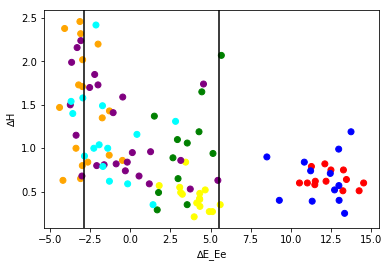

In [151]:
outputpath=r'C:\Users\PC\Dropbox\cai\btype_cco\crg_data\IntHvsDeltaE.png'  # path to store the figure

def colormaps(color_map, column):
    '''
    color each row by column value based on colormap .
    '''
    n=len(column)
    ans=[''] * n
    for i, x in enumerate(column):
        ans[i]=color_map.get(x,'blue')
        #print(x, ans[i])
    return ans
    
color_maps={"p1": "orange", "dddro": "orange", "p2": "purple", "pddro": "purple", "p3": "green", "ppdro": "green",\
           "p4": "cyan","dpdro": "cyan", "d372p":"yellow", "d372ph376p": "red"}
colors=colormaps(color_maps, df_res['traj/xray'])


plt.figure()
plt.scatter(df_res[r'$\bigtriangleup$E_e1'], df_res[r'$\int$dsum_excludepls24_m2'], color=colors)
plt.xlabel('∆E_Ee')
plt.ylabel('∆H')
plt.axvline(x=-2.9,color='k')
plt.axvline(x=5.5,color='k')
#plt.savefig(outputpath, dpi=300)
plt.show()

In [152]:
outputpath=r'/Users/caixiuhong/Dropbox/cai/btype_cco/crg_data/IntHvsDeltaE2_excludepls24.png'  # path to store the figure


def colormaps(color_map, column):
    '''
    color each row by column value based on colormap .
    '''
    n=len(column)
    ans=[''] * n
    for i, x in enumerate(column):
        ans[i]=color_map.get(x,'blue')
        #print(x, ans[i])
    return ans
    
color_maps={"p1": "orange", "dddro": "orange", "p2": "purple", "pddro": "purple", "p3": "green", "ppdro": "green",\
           "p4": "cyan","dpdro": "cyan", "d372p":"yellow", "d372ph376p": "red"}
colors=colormaps(color_maps, df_res['traj/xray'])

"""
fig, ax1=plt.subplots(figsize=(10,10))
color = 'tab:red'
ax1.scatter(df_res[r'$\bigtriangleup$E_e1'], df_res[r'$\int$dsum_pls6_m2'],marker='x',color=colors)
ax1.set_xlabel('∆∆GEe(UL-L)')
ax1.set_ylabel('∆H+', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(x=-2.9,color='k')
ax1.axvline(x=5.5,color='k')

color = 'k'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.errorbar(df_res[r'$\bigtriangleup$E_e1'],df_res['sum_pls6_avecrg'],df_res['sum_pls6_std'],linestyle='None', marker='.', color='k')
ax2.set_ylabel('ionization state',color=color)
ax2.set_ylim((-10.0, -2.0)) 
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

#plt.savefig(outputpath, dpi=300)
plt.show()
"""


fig, ax=plt.subplots(2)
ax[1].scatter(df_res[r'$\bigtriangleup$E_e1'], df_res[r'$\int$dsum_excludepls24_m2'],\
              edgecolors='k', linewidth='0.5', marker='o',color=colors, s=10)
ax[1].set_xlabel(r'$\bigtriangleup$$\bigtriangleup$GEe(UL-L)')
ax[1].set_ylabel(r'$\bigtriangleup$H+')
ax[1].tick_params(axis='y')
ax[1].axvline(x=-2.9,color='k')
ax[1].axvline(x=5.5,color='k')

ax[0].plot(df_res[r'$\bigtriangleup$E_e1'],df_res['sum_excludepls24_avecrg'], 'ro', markersize=3)
#ax[0].errorbar(df_res[r'$\bigtriangleup$E_e1'],df_res['sum_pls6_avecrg'],df_res['sum_pls6_std'], \
#               uplims=df_res['sum_pls6_maxcrg'],linestyle='None', \
#               capsize=3, color='k')
ax[0].errorbar(df_res[r'$\bigtriangleup$E_e1'],df_res['sum_excludepls24_avecrg'],\
               [df_res['sum_excludepls24_avecrg']-df_res['sum_excludepls24_mincrg'],\
                df_res['sum_excludepls24_maxcrg']-df_res['sum_excludepls24_avecrg']], \
               linestyle='None', \
               capsize=1, color='k', lw=0.5)

ax[0].set_ylabel('ionization state')
#ax[0].set_ylim((-10.0, -2.0)) 
#ax[0].tick_params(axis='y' )
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig(outputpath, dpi=300)
fig.show()

/Users/caixiuhong/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


# group the data by traj/xray and summarize the information

In [13]:
groups=df_res.groupby('traj/xray')[[r'$\int$dsum_pls6_m2','sum_pls6_avecrg',r'$\bigtriangleup$E_e1',r'$\bigtriangleup$E_f3']]\
.agg(['mean','std','size']).reset_index()

# style the dataframe and save the dataframe to excel file

In [14]:
def color_struc(s, color_map, column):
    '''
    color each row by column value based on colormap .
    '''
    #copy df to new - original data are not changed
    df = s.copy()
    #set by condition
    df.loc[:,:] = 'background-color: blue '
    for key in color_map:
        
        mask = s[column] == key
        #print(mask)
        df.loc[mask, :] = 'background-color: {}'.format(color_map.get(key))
    #print(df)
    return df    

#colormap of each structure
color_maps={"p1": "orange", "dddro": "orange", "p2": "purple", "pddro": "purple", "p3": "green", "ppdro": "green",\
           "p4": "cyan","dpdro": "cyan", "d372p":"yellow", "d372ph376p": "red"}

df_res_styler=df_res.round(2).style.apply(color_struc, color_map=color_maps, column='traj/xray', axis=None)

In [334]:
'''
outputpath=r'C:\Users\PC\Dropbox\cai\btype_cco\crg_data\summary_96md_12xry_alys.xlsx'
writer=pandas.ExcelWriter(outputpath,engine = 'xlsxwriter')

df_res_styler.to_excel(writer,sheet_name='complete_data')
df_res_styler.to_excel(writer, \
                       sheet_name='brief_data',\
                       columns=['state_snap', 'traj/xray', 'time_point','cluster_size',
                                'PAAK9301_avecrg±std',  'PDDK9302_avecrg±std',
                                'DA0287_avecrg±std', 'DA0372_avecrg±std', 'HA0376_avecrg±std', 'EB0126_avecrg±std',
                                'sum_pls6_avecrg', 'sum_pls6_std',
       'sum_pls6_avecrg±std', '$\int$dsum_pls6_m1', '$\int$dsum_pls6_m2',
       'E(-3)_min_e1', 'E(-4)_min_e1',
       'E_self(-3)_e1', 'E_self(-4)_e1', 'E_pw(-3)_e1', 'E_pw(-4)_e1',
       'E_mfe(-3)_e1', 'E_mfe(-4)_e1', r'$\bigtriangleup$E_e1',
       r'$\bigtriangleup$E_self_e1', r'$\bigtriangleup$E_pw_e1',
       r'$\bigtriangleup$E_mfe_e1', 'E(-3)_min_f3', 'E(-4)_min_f3',
        'E_self(-3)_f3', 'E_self(-4)_f3',
       'E_pw(-3)_f3', 'E_pw(-4)_f3', 'E_mfe(-3)_f3', 'E_mfe(-4)_f3',
       r'$\bigtriangleup$E_f3', r'$\bigtriangleup$E_self_f3',
       r'$\bigtriangleup$E_pw_f3', r'$\bigtriangleup$E_mfe_f3'])
groups.round(2).to_excel(writer, sheet_name='groupbytraj')
writer.save()
writer.close()
'''

C:\Users\PC\Anaconda3\lib\site-packages\pandas\io\formats\excel.py:305: CSSWarning: Unhandled colour format: 'cyan'
  warnings.warn('Unhandled colour format: %r' % val, CSSWarning)
